In [11]:
import time
from pynq import Overlay
import pynq.lib.dma
from pynq import Xlnk
import numpy as np
import asyncio
from psutil import cpu_percent
import matplotlib.pyplot as plt
import scipy.signal as signal


In [12]:
sw_dft = np.fft.fft # software DFT
length = 1024 # this is our DFT size
no_signals = 4 # number of test signals
all_inps = np.empty([length*no_signals,], dtype=np.complex) # we will use it as input to our HLS core
all_outs_sw = np.empty([length*no_signals,], dtype=np.complex) # this is our reference to test our design error
all_outs_hw = np.empty([length*no_signals,], dtype=np.complex) # output of HLS will be saved in this array

In [13]:
#%in_buffer_i = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer 1
#in_buffer_q = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer 2

i_in = list()
q_in = list()

i_out = list()
q_out = list()

data = np.zeros(35000)

sym_out = list()
#np.ndarray.data[0:35000] = 0;

# parse through input file and split into i and q
in_data = np.loadtxt("input.dat")
i_in = in_data[0:35000,0]
q_in = in_data[0:35000,1]


# load golden output data into array
out_gold_file = np.loadtxt("out.gold.dat")
#out_gold_data = out_gold_file[10000:10100]
#print(out_gold_data)
#print(i_in)
#print(q_in)

#with open("input.dat", "r") as f_input:
#    for line in f_i:
#        i_in.append(float(line))
#        #in_buffer_i.append(float(line))

{'axi_dma_0': {'phys_addr': 1077936128, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_0', 'driver': <class 'pynq.lib.dma.DMA'>}, 'axi_dma_1': {'phys_addr': 1078001664, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_1', 'driver': <class 'pynq.lib.dma.DMA'>}, 'axi_dma_2': {'phys_addr': 1078067200, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_2', 'driver': <class 'pynq.lib.dma.DMA'>}, 'ofdm_receiver_0': {'phys_addr': 1136656384, 'addr_range': 65536, 'type': 'xilinx.com:hls:ofdm_receiver:1.0', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'ofdm_receiver_0', 'driver': <class 'pynq.overlay.DefaultIP'>}}
0.4218728542327881 seconds to program bitstream
processing buffer_0 ...
processing sig_0 is done.
processing buffer_1 ...
processing sig_1 is done.
pr

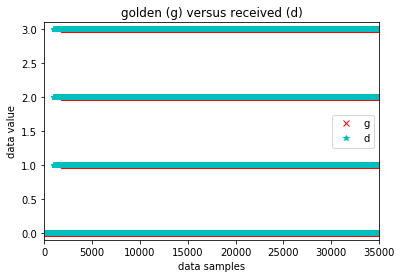

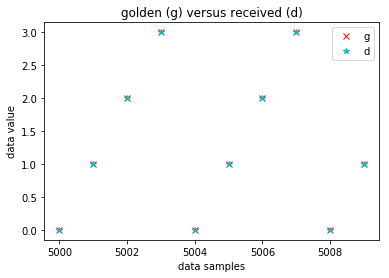

error rate =  0.0044571428571428574


In [73]:
# HLS register addresses
IP_CTRL = 0x00
AP_START = 0x1
GIER = 0x04
IP_IER = 0x08
IP_ISR = 0x0C
INTRPT_AP_DONE = 0x1
INTRPT_AP_READY = 0x2

ol = Overlay('ofdm_receiver.bit') # load bitstream - check against your bitstream name and location
t_before_bitstream = time.time()
ol.download() # download bitstream to FPGA
print(ol.ip_dict)  # print overlay contents
t_after_bitstream = time.time()
print(t_after_bitstream - t_before_bitstream, 'seconds to program bitstream')

dmaSYM = ol.axi_dma_2 # third dma.  Connected to symbol output (QPSK decoder)
dmaII = ol.axi_dma_1 # first dma. Connected to inpI and outI
dmaRR = ol.axi_dma_0 # second dma. Connected to inpR and outR
ofdm_ip = ol.ofdm_receiver_0 # HLS core
ofdm_ip.write(GIER, 0x1) # disable interrupts

xlnk = Xlnk()
inp_bufferI = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer I
inp_bufferR = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer R
out_bufferI = xlnk.cma_array(shape=(length,), dtype=np.float32) # output buffer I
out_bufferR = xlnk.cma_array(shape=(length,), dtype=np.float32) # output buffer R
out_bufferSYM = xlnk.cma_array(shape=(length,), dtype = np.int) # output buffer SYM

t_before = time.time()
#for i in range(no_signals):
for i in range(0,34):
    print('processing buffer_{} ...'.format(i))
    #np.copyto(inp_bufferI, all_inps[length*i:length*(i+1)].imag) # copy input.imag to input buffer I
    #np.copyto(inp_bufferR, all_inps[length*i:length*(i+1)].real) # copy input.real to input buffer R
   
    
    j = i*length
    k = (i+1)*length

    np.copyto(inp_bufferI[0:1024], q_in[j:k]) # copy imaginary input data to input buffer I
    np.copyto(inp_bufferR[0:1024], i_in[j:k]) # copy real input data to input buffer R
    
    #np.copyto(inp_bufferI, i_in) # copy imaginary input data to input buffer I
    #np.copyto(inp_bufferR, q_in) # copy real input data to input buffer R
    
    dmaII.sendchannel.transfer(inp_bufferI) # write input buffer I to dmaII.inp
    dmaRR.sendchannel.transfer(inp_bufferR) # write input buffer R to dmaRR.inp
    dmaII.recvchannel.transfer(out_bufferI) # write dmaII.out to output buffer I
    dmaRR.recvchannel.transfer(out_bufferR) # write dmaRR.out to output buffer R
    dmaSYM.recvchannel.transfer(out_bufferSYM) # write the dmaSYM.out to output buffer symbols
    
    ofdm_ip.write(IP_CTRL, AP_START) # start the core
    dmaII.sendchannel.wait()
    dmaRR.sendchannel.wait()
    dmaII.recvchannel.wait()
    dmaRR.recvchannel.wait()
    dmaSYM.recvchannel.wait()
    
    #print(i, "output buffer (I)", out_bufferI)
    #print(i, "output buffer (R)", out_bufferR)
    
    np.copyto(data[j:k], out_bufferSYM[0:1024])
    
    #np.copyto(all_outs_hw[length*i:length*(i+1)].imag, out_bufferI) # copy output buffer I to output.imag
    #np.copyto(all_outs_hw[length*i:length*(i+1)].real, out_bufferR) # copy output buffer R to output.real
    
    # np.copyto(all_outs_hw[length*i:length*(i+1)], out_bufferSYM) # copy output buffer SYM 
    print('processing sig_{} is done.'.format(i))    
t_after = time.time()   

np.copyto(inp_bufferI[0:184], q_in[34816:35000]) # copy imaginary input data to input buffer I
np.copyto(inp_bufferR[0:184], i_in[34816:35000]) # copy real input data to input buffer R

np.copyto(inp_bufferI[184:length], 0) # copy imaginary input data to input buffer I
np.copyto(inp_bufferR[184:length], 0) 

dmaII.sendchannel.transfer(inp_bufferI) # write input buffer I to dmaII.inp
dmaRR.sendchannel.transfer(inp_bufferR) # write input buffer R to dmaRR.inp
dmaII.recvchannel.transfer(out_bufferI) # write dmaII.out to output buffer I
dmaRR.recvchannel.transfer(out_bufferR) # write dmaRR.out to output buffer R
dmaSYM.recvchannel.transfer(out_bufferSYM) # write the dmaSYM.out to output buffer symbols
    
ofdm_ip.write(IP_CTRL, AP_START) # start the core
dmaII.sendchannel.wait()
dmaRR.sendchannel.wait()
dmaII.recvchannel.wait()
dmaRR.recvchannel.wait()
dmaSYM.recvchannel.wait()
    
np.copyto(data[j:k], out_bufferSYM[0:1024])

print('\n{} seconds to run on HW\n'.format(t_after - t_before))

#print(out_bufferI)
#print(out_bufferR)

inp_bufferI.close()
inp_bufferR.close()
out_bufferI.close()
out_bufferR.close()
out_bufferSYM.close()

'''
print("last output buffer (I)", out_bufferI)
print("last output buffer (R)", out_bufferR)
'''

mock_output = out_gold_file + 0.1 # create mock received data for plot testing

#out_gold_file = out_gold_file[0:35000]

n = np.arange(0,35000)
plt.figure(1)
plt.plot(n,out_gold_file[0:35000], 'rx', n, data[0:35000], 'c*' )
plt.axis([0,35000,-0.1,3.1])
#plt.plot(out_gold_file, 'ro',  data, 'c*' )
plt.grid
plt.title('golden (g) versus received (d)')
plt.xlabel('data samples')
plt.ylabel('data value')
plt.legend('gd')
plt.show()
#plt.axis([20000 21024 -0.1 4])
#plt.hold
#plt.stem(mock_output[20000:20050], 'r')

#plt.figure(2)
#plt.plot(q_in[0:35000], 'rx',i_in[0:35000], 'c*')
#plt.holdon
#plt.plot(data[34900:34910], 'c*')
#plt.plot(out_gold_file[750:1250], 'c*' )
#plt.grid
#plt.title('input')
#plt.xlabel('data samples')
#plt.ylabel('data value')
#plt.legend('gd')
#plt.show()

n10 = np.arange(5000,5010)
plt.figure(2)
plt.plot(n10, out_gold_file[5000:5010], 'rx', n10, data[5000:5010], 'c*')
#plt.holdon
#plt.plot(data[34900:34910], 'c*')
#plt.plot(out_gold_file[750:1250], 'c*' )
plt.grid
plt.title('golden (g) versus received (d)')
plt.xlabel('data samples')
plt.ylabel('data value')
plt.legend('gd')
plt.show()

#n1024 = np.arange(0,1024)
#plt.figure(4)
#plt.plot(n1024,inp_bufferI, 'c*', n1024, inp_bufferR, 'rx')

'''
print(inp_bufferI)
print(inp_bufferR)
'''


#print('size of output data:', np.size(data))   # print size of out_gold_file array
error_count = 0
for m in range(0,35000):
    #error = np.sqrt(np.mean(out_gold_file[length*m:length*(m+1)] - data[length*m:length*(m+1)]))
    if out_gold_file[m] != data[m]:
        error_count = error_count + 1
        
print("error rate = ", (error_count-length)/35000)
                    
#error_R = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].real - all_outs_hw[length*i:length*(i+1)].real)**2))
#    error_I = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].imag - all_outs_hw[length*i:length*(i+1)].imag)**2))
#    error_R = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].real - all_outs_hw[length*i:length*(i+1)].real)**2))
#    print('sig_{}: Imag error={}, Real error={}\n'.format(i, error_I, error_R))